In [34]:
import requests
import zipfile
from pathlib import Path
import torch
# Setup path to a data folder
data_path = Path("../../")
image_path = data_path / "ICIP_denoised_data/Data_1"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print("DataNotFound !!!")

../../ICIP_denoised_data/Data_1 directory already exists... skipping download


In [35]:
!pwd

/app/ieee/code/Classification-Clustering


In [36]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('../../ICIP_denoised_data/Data_1/train'),
 PosixPath('../../ICIP_denoised_data/Data_1/test'))

## Define Models

In [37]:
BATCH_SIZE = 64
IMG_SIZE = (128,128)
PATCH_SIZE = (8,8)
# Number of patch in one sequence
NUM_PATCH = int((IMG_SIZE[0] / PATCH_SIZE[0])**2)
# Number of patch out after feature extracting
T = int(NUM_PATCH / 4)
# Number of attention head
NUM_H = 4
# Number of Transformer Block
NUM_TR = 11

In [38]:
BATCH_SIZE = 64
IMG_SIZE = (128,128)
PATCH_SIZE = (8,8)
# Number of patch in one sequence
NUM_PATCH = int((IMG_SIZE[0] / PATCH_SIZE[0])**2)
# Number of patch out after feature extracting
T = int(NUM_PATCH / 4)
# Number of attention head
NUM_H = 4
# Number of Transformer Block
NUM_TR = 11

# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

import torch
import torchvision
assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")



# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import os
from torch import nn
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"


my_transform = transforms.Compose([
                                    transforms.Resize((IMG_SIZE)),
                                    transforms.ToTensor()
])

def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x


class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )



    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x


class Transpose(nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        self.dim1 = dim1
        self.dim2 = dim2

    def forward(self, x):
        return x.transpose(self.dim1, self.dim2)


class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim,n_feature, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0,use_mlp_head=True):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size
        self.use_mlp = use_mlp_head
        # Layers/Networks
        # self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        # self.input_layer = FeatureExtractor(n_feature,embed_dim)
        self.input_layer = nn.Sequential(
            nn.Conv3d(3 , n_feature*3 , kernel_size = 3 , padding=1 , stride=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,1,1) , stride=(2,1,1) , padding=(0,0,0)),

            nn.Conv3d(n_feature*3 , n_feature*6 , 3 , padding=1 , stride=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,1,1) , stride=(2,1,1) , padding=(0,0,0)),
            nn.Conv3d(n_feature*6 , n_feature*8 , 3 , padding=1 , stride=1),

            Transpose(2,1),
            nn.Flatten(2,-1),
            nn.Linear(n_feature*8*PATCH_SIZE[0]*PATCH_SIZE[0] ,embed_dim )


        )
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
            # torch.nn.Softmax(dim=1)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+int(NUM_PATCH / 4),embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size , flatten_channels=False).transpose(1,2)
        # print(x.shape)
        B, _, _ , _ , _= x.shape
        T = int(NUM_PATCH / 4)
        x = self.input_layer(x)
        # print(x.shape)
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        out = self.transformer(x)

        # Perform classification prediction
        if self.use_mlp : 
            cls = out[0]
            out = self.mlp_head(cls)
        return out

torch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


In [39]:
class SiamesNet (nn.Module):
    def __init__(self,use_pretrain=True):
        super().__init__()
        # Define model
        self.model = VisionTransformer(embed_dim = 256 ,
                            hidden_dim = 512,
                            n_feature=8 ,
                            num_channels = 3,
                            num_heads = NUM_H ,
                            num_layers = NUM_TR ,
                            num_classes=4,
                            patch_size=PATCH_SIZE[0] ,
                            num_patches=NUM_PATCH ,
                            dropout=0.1 ,
                            use_mlp_head=False).to(device)
        # load model weights
        if (use_pretrain):
            name = "../../../Ablation_Study/TrackExp/BestWeight_Part_19_Epoch_2_TrainLoss_0.01639417985006382_TestLoss_0.027976555515579093TrainAcc_0.9941451149425288_Testacc_0.9951171875.pth"
            # Compile the model
            torch.set_float32_matmul_precision('high')
            self.model = torch.compile(self.model)
            self.model.load_state_dict(torch.load(name))

    def forward_once(self, x):
        return self.model(x)

    def forward(self, input1, input2):
        output1 = self.model(input1)
        output2 = self.model(input2)
        return output1, output2

## Find Non-dme first

In [40]:
AmirModel = VisionTransformer(embed_dim = 256 , 
                            hidden_dim = 512,
                            n_feature=8 ,
                            num_channels = 3, 
                            num_heads = NUM_H , 
                            num_layers = NUM_TR ,
                            num_classes=4,
                            patch_size=PATCH_SIZE[0] ,
                            num_patches=NUM_PATCH , 
                            dropout=0.1 ,
                             use_mlp_head=True).to(device)

**************************************************************************************

In [41]:
# Compile the model 
torch.set_float32_matmul_precision('high')
AmirModel = torch.compile(AmirModel)

In [43]:
AmirModel = nn.Sequential(AmirModel,nn.Linear(4,2)).to(device)

In [44]:
AmirModel.load_state_dict(torch.load("./Classification/TrackExp/BestWeight_Part_ICIP_Epoch_5_TrainLoss_0.4750620827726696_TestLoss_0.5060631077865074TrainAcc_0.8385469948849105_Testacc_0.7650862068965517.pth"))

<All keys matched successfully>

## Define function to draw coonfusion marix

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def draw_cm(true , pred , title ):
    # make confustion matrix for train class
    cm = confusion_matrix(true,pred)
    display = ConfusionMatrixDisplay(cm)
    display.plot(cmap="Blues")
    plt.title(title)
    plt.show();

## Find others train

In [46]:
First_clf_train = {"Path":[],
               "True_label":[],
               "P1":[],
               "P2":[]}
num_folder = len(os.listdir(train_dir))
with torch.inference_mode():
    for class_path in os.listdir(train_dir):
        if class_path in ["0","1","2"]:
            True_label = "2" if class_path == "2" else "1"
            class_path = os.path.join(train_dir,class_path)
            for folder_path in os.listdir(class_path):
                folder_path = os.path.join(class_path,folder_path)
                print(folder_path)
                l = []
                for image_path in tqdm(os.listdir(folder_path)):
                    # print(image_path)
                    img = my_transform(Image.open(os.path.join(folder_path , image_path)).convert("RGB")).unsqueeze(dim=0)
                    # print(img.shape)
                    out = AmirModel(img.to(device))
                    l.append(torch.softmax(out,dim=1).squeeze().detach().cpu().numpy())
                prob = sum(l) / len(l)
                First_clf_train["Path"].append(folder_path)
                First_clf_train["True_label"].append(True_label)
                try:
                    First_clf_train["P1"].append(prob[0])
                except:
                    First_clf_train["P1"].append(0)
                try:
                    First_clf_train["P2"].append(prob[1])
                except:
                    First_clf_train["P2"].append(0)

../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (9)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:06<00:00, 23.98it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:01<00:00, 159.94it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 156.27it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (15)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:01<00:00, 159.45it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (7)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 161.54it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (16)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 159.67it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:01<00:00, 160.98it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (14)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 160.95it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (19)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 178.82it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 203.35it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (10)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 175.58it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (20)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 172.32it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (22)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 164.83it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (18)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:01<00:00, 161.04it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:01<00:00, 161.84it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 187.34it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (23)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 135.48it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (5)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.10it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (11)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 161.58it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (21)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 157.86it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:01<00:00, 152.26it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (4)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:01<00:00, 157.98it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (6)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:01<00:00, 158.30it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (17)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 161.83it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (9)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:00<00:00, 161.83it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (21)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:01<00:00, 163.45it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (12)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 182.22it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (20)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 191.85it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (10)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:01<00:00, 170.69it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:01<00:00, 162.39it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (17)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 160.10it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (16)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 162.85it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (11)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:01<00:00, 162.26it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (5)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 159.69it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (19)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 162.69it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:01<00:00, 162.05it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (22)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:01<00:00, 162.32it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (18)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 162.19it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (14)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 162.35it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (15)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 157.87it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (23)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 154.59it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (6)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 162.52it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:01<00:00, 160.78it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 152.40it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (4)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 160.37it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 160.66it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (7)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:01<00:00, 161.98it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (10)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:01<00:00, 162.22it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (20)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 160.48it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 162.41it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 162.16it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (33)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:01<00:00, 160.33it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (7)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:01<00:00, 146.97it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (29)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:01<00:00, 168.82it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (30)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 214.44it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (22)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 252.73it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (21)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 247.65it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 252.17it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:01<00:00, 248.59it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (9)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 228.74it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 258.73it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 250.04it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (14)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 260.09it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (19)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 250.56it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (32)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 250.56it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 254.97it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (34)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 256.73it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (15)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 257.14it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (23)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 273.27it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (18)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 266.61it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 244.53it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (26)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 256.42it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (25)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:01<00:00, 234.91it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (16)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 249.97it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (27)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 254.09it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 254.95it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (6)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 251.37it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:01<00:00, 255.68it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (11)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 252.39it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (31)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 247.53it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (17)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 260.07it/s]


In [47]:
prob

array([0.9244158 , 0.07558421], dtype=float32)

In [48]:
First_clf_train_df= pd.DataFrame(First_clf_train)
First_clf_train_df.to_csv("./Results/First_clf_train.csv",index=False)
First_clf_train_df

,Path,True_label,P1,P2
0,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.785465,0.214535
1,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.904253,0.095746
2,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.702123,0.297877
3,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.706547,0.293453
4,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.828199,0.171801
...,...,...,...,...
76,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.625706,0.374293
77,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.804025,0.195975
78,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.867527,0.132473
79,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.877288,0.122713


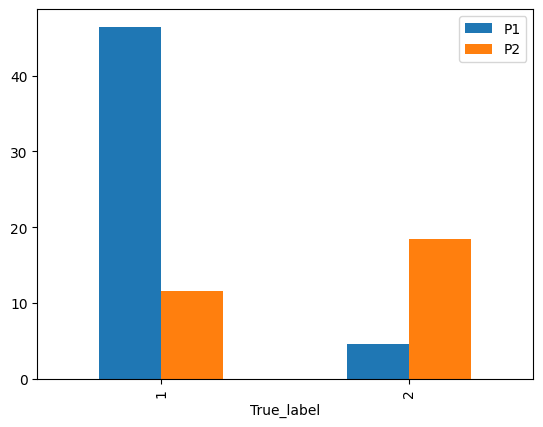

In [49]:
First_clf_train_df.groupby(["True_label"]).sum().plot(kind="bar");

### PRED

In [50]:
def PRED(x):
    if x["P1"] > x["P2"]:
            p = "1"
    else:
            p = "2"
    return p

In [51]:
First_clf_train_df["PRED"] = First_clf_train_df.apply(PRED,axis=1)
First_clf_train_df.to_csv("./Results/First_clf_train.csv",index=False)
First_clf_train_df

,Path,True_label,P1,P2,PRED
0,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.785465,0.214535,1
1,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.904253,0.095746,1
2,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.702123,0.297877,1
3,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.706547,0.293453,1
4,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.828199,0.171801,1
...,...,...,...,...,...
76,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.625706,0.374293,1
77,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.804025,0.195975,1
78,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.867527,0.132473,1
79,../../ICIP_denoised_data/Data_1/train/0/RawDat...,1,0.877288,0.122713,1


In [52]:
Others_train_subjects = First_clf_train_df[First_clf_train_df["PRED"] == "1"]["Path"]
len(Others_train_subjects)

58

In [53]:
Dme_train_subjects = First_clf_train_df[First_clf_train_df["PRED"] == "2"]["Path"]
len(Dme_train_subjects)

23

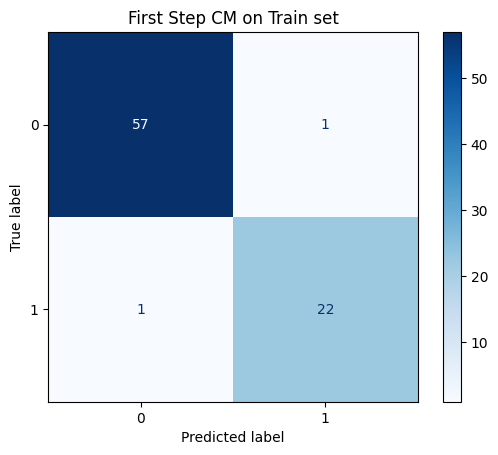

In [54]:
# Draw cm
draw_cm(First_clf_train_df["True_label"],First_clf_train_df["PRED"],"First Step CM on Train set")

## Find others test

In [55]:
First_clf_test = {"Path":[],
               "True_label":[],
               "P1":[],
               "P2":[]}
with torch.inference_mode():
    for class_path in os.listdir(test_dir):
        if class_path in ["0","1","2"]:
            True_label = "2" if class_path == "2" else "1"
            class_path = os.path.join(test_dir,class_path)
            for folder_path in os.listdir(class_path):
                folder_path = os.path.join(class_path,folder_path)
                print(folder_path)
                l = []
                for image_path in tqdm(os.listdir(folder_path)):
                    # print(image_path)
                    img = my_transform(Image.open(os.path.join(folder_path , image_path)).convert("RGB")).unsqueeze(dim=0)
                    # print(img.shape)
                    out = AmirModel(img.to(device))
                    l.append(torch.softmax(out,dim=1).squeeze().detach().cpu().numpy())
                prob = sum(l) / len(l)
                First_clf_test["Path"].append(folder_path)
                First_clf_test["True_label"].append(True_label)
                try:
                    First_clf_test["P1"].append(prob[0])
                except:
                    First_clf_test["P1"].append(0)
                try:
                    First_clf_test["P2"].append(prob[1])
                except:
                    First_clf_test["P2"].append(0)

../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (25)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 281.43it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (29)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 288.86it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:01<00:00, 276.24it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (30)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 287.47it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (26)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:01<00:00, 293.17it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (27)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 257.08it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (25)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 288.41it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (27)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:00<00:00, 263.58it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 280.49it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 283.31it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (26)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 280.77it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (41)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 280.90it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (38)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:01<00:00, 270.24it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (37)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:01<00:00, 256.53it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (42)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 268.43it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (35)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:01<00:00, 265.45it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (36)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:01<00:00, 271.56it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (40)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 276.90it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (39)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 250.41it/s]


In [56]:
First_clf_test_df= pd.DataFrame(First_clf_test)
First_clf_test_df.to_csv("First_clf_test.csv",index=False)
First_clf_test_df

,Path,True_label,P1,P2
0,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.841295,0.158706
1,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.884494,0.115506
2,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.710169,0.289831
3,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.869026,0.130974
4,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.895720,0.104279
5,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.784953,0.215047
6,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.736910,0.263090
7,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.476639,0.523361
8,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.827296,0.172704
9,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.598553,0.401447


In [57]:
First_clf_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Path        19 non-null     object 
 1   True_label  19 non-null     object 
 2   P1          19 non-null     float32
 3   P2          19 non-null     float32
dtypes: float32(2), object(2)
memory usage: 584.0+ bytes


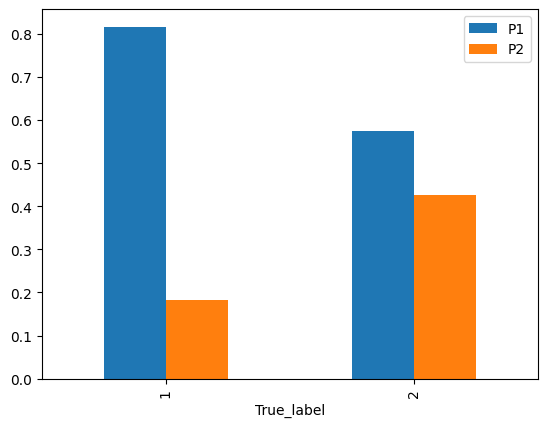

In [58]:
First_clf_test_df.drop(columns=["Path"]).groupby(["True_label"]).mean().plot(kind="bar");

### PRED

In [59]:
First_clf_test_df["PRED"] = First_clf_test_df.apply(PRED,axis=1)
First_clf_test_df.to_csv("./Results/First_clf_test.csv",index=False)
First_clf_test_df

,Path,True_label,P1,P2,PRED
0,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.841295,0.158706,1
1,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.884494,0.115506,1
2,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.710169,0.289831,1
3,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.869026,0.130974,1
4,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.895720,0.104279,1
5,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.784953,0.215047,1
6,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.736910,0.263090,1
7,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.476639,0.523361,2
8,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.827296,0.172704,1
9,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.598553,0.401447,1


In [60]:
Others_test_subjects = First_clf_test_df[First_clf_test_df["PRED"] == "1"]["Path"]
len(Others_test_subjects)

17

In [61]:
Dme_test_subjects = First_clf_test_df[First_clf_test_df["PRED"] == "2"]["Path"]
len(Dme_test_subjects)

2

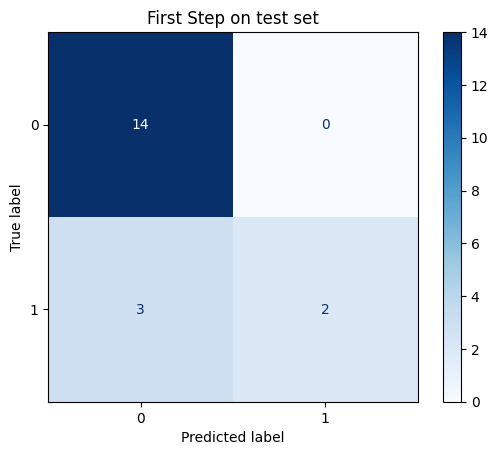

In [62]:
# Draw cm
draw_cm(First_clf_test_df["True_label"],First_clf_test_df["PRED"],title="First Step on test set")

## Load Snn weights

In [63]:
AmirModel = SiamesNet().to(device)
# load weights
AmirModel.load_state_dict(torch.load("./Siamese/TrackExp/siameseNet_50epoch_margin=10_calss_2_Normal(0)_Dme(1)_final_denoise.pth"))

<All keys matched successfully>

## Train Cluster

In [64]:
"../../ICIP_PCA_SPLIT/train/0/RawDataQA (6)" in Others_train_subjects.values

False

In [65]:
l = []
with torch.inference_mode():
    for class_path in os.listdir(train_dir):
        if class_path in ["0","1","2"]:
            class_path = os.path.join(train_dir,class_path)
            for folder_path in os.listdir(class_path):
                folder_path = os.path.join(class_path,folder_path)
                print(folder_path)
                if folder_path in Others_train_subjects.values:
                    for image_path in tqdm(os.listdir(folder_path)):
                        # print(image_path)
                        img = my_transform(Image.open(os.path.join(folder_path , image_path)).convert("RGB")).unsqueeze(dim=0)
                        # print(img.shape)
                        out = AmirModel.forward_once(img.to(device))
                        l.append(out.squeeze().detach().cpu().numpy())

../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (9)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:05<00:00, 29.07it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:01<00:00, 289.01it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 295.01it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (15)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 270.99it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (7)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 281.09it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (16)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 294.34it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:01<00:00, 292.41it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (14)
../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (19)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 295.63it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 297.22it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (10)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 284.45it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (20)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 297.87it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (22)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 274.49it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (18)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 292.41it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 292.59it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 278.48it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (23)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 274.04it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (5)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 293.39it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (11)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 290.39it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (21)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 292.19it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 280.74it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (4)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 285.99it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (6)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 285.20it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (17)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 273.02it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (9)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (21)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (12)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (20)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (10)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (13)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (17)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (16)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (11)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (5)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (19)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (8)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (22)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (18)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (14)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (15)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (23)
../../ICIP_denoised_data/Data_1/tr

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 289.35it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (7)
../../ICIP_denoised_data/Data_1/train/0/RawDataQA (10)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 289.57it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (20)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 275.83it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 294.97it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 282.88it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (33)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 284.52it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (7)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 269.21it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (29)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:01<00:00, 264.62it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (30)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 272.88it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (22)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 268.84it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (21)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 269.33it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 267.42it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 280.07it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (9)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 269.56it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 276.70it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 270.46it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (14)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 274.35it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (19)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 251.80it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (32)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 266.70it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 245.47it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (34)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 257.97it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (15)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 275.88it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (23)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 280.73it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (18)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 273.75it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 278.63it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (26)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 273.11it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (25)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:01<00:00, 271.31it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (16)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 277.42it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (27)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 231.36it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 204.49it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (6)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 253.89it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 259.96it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (11)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 269.67it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (31)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 268.77it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (17)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 250.59it/s]


In [66]:
l = np.asarray(l)
l.shape

(10181, 65, 256)

In [67]:
l.reshape(-1,65,256)[:,:,0].shape


(10181, 65)

In [68]:
l = l.reshape(l.shape[0],-1)
l.shape

(10181, 16640)

In [69]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(l)

In [70]:
pred = kmeans.labels_
pred

array([1, 0, 1, ..., 0, 0, 0], dtype=int32)

In [71]:
import pandas as pd
pd.DataFrame(pred).value_counts(normalize=True)

0    0.638051
1    0.361949
Name: proportion, dtype: float64

## Visualize with PCA

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


In [53]:
composition = pca.fit_transform(l)
composition.shape

(10275, 2)

/tmp/ipykernel_24460/382068089.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('summer', num_classes)


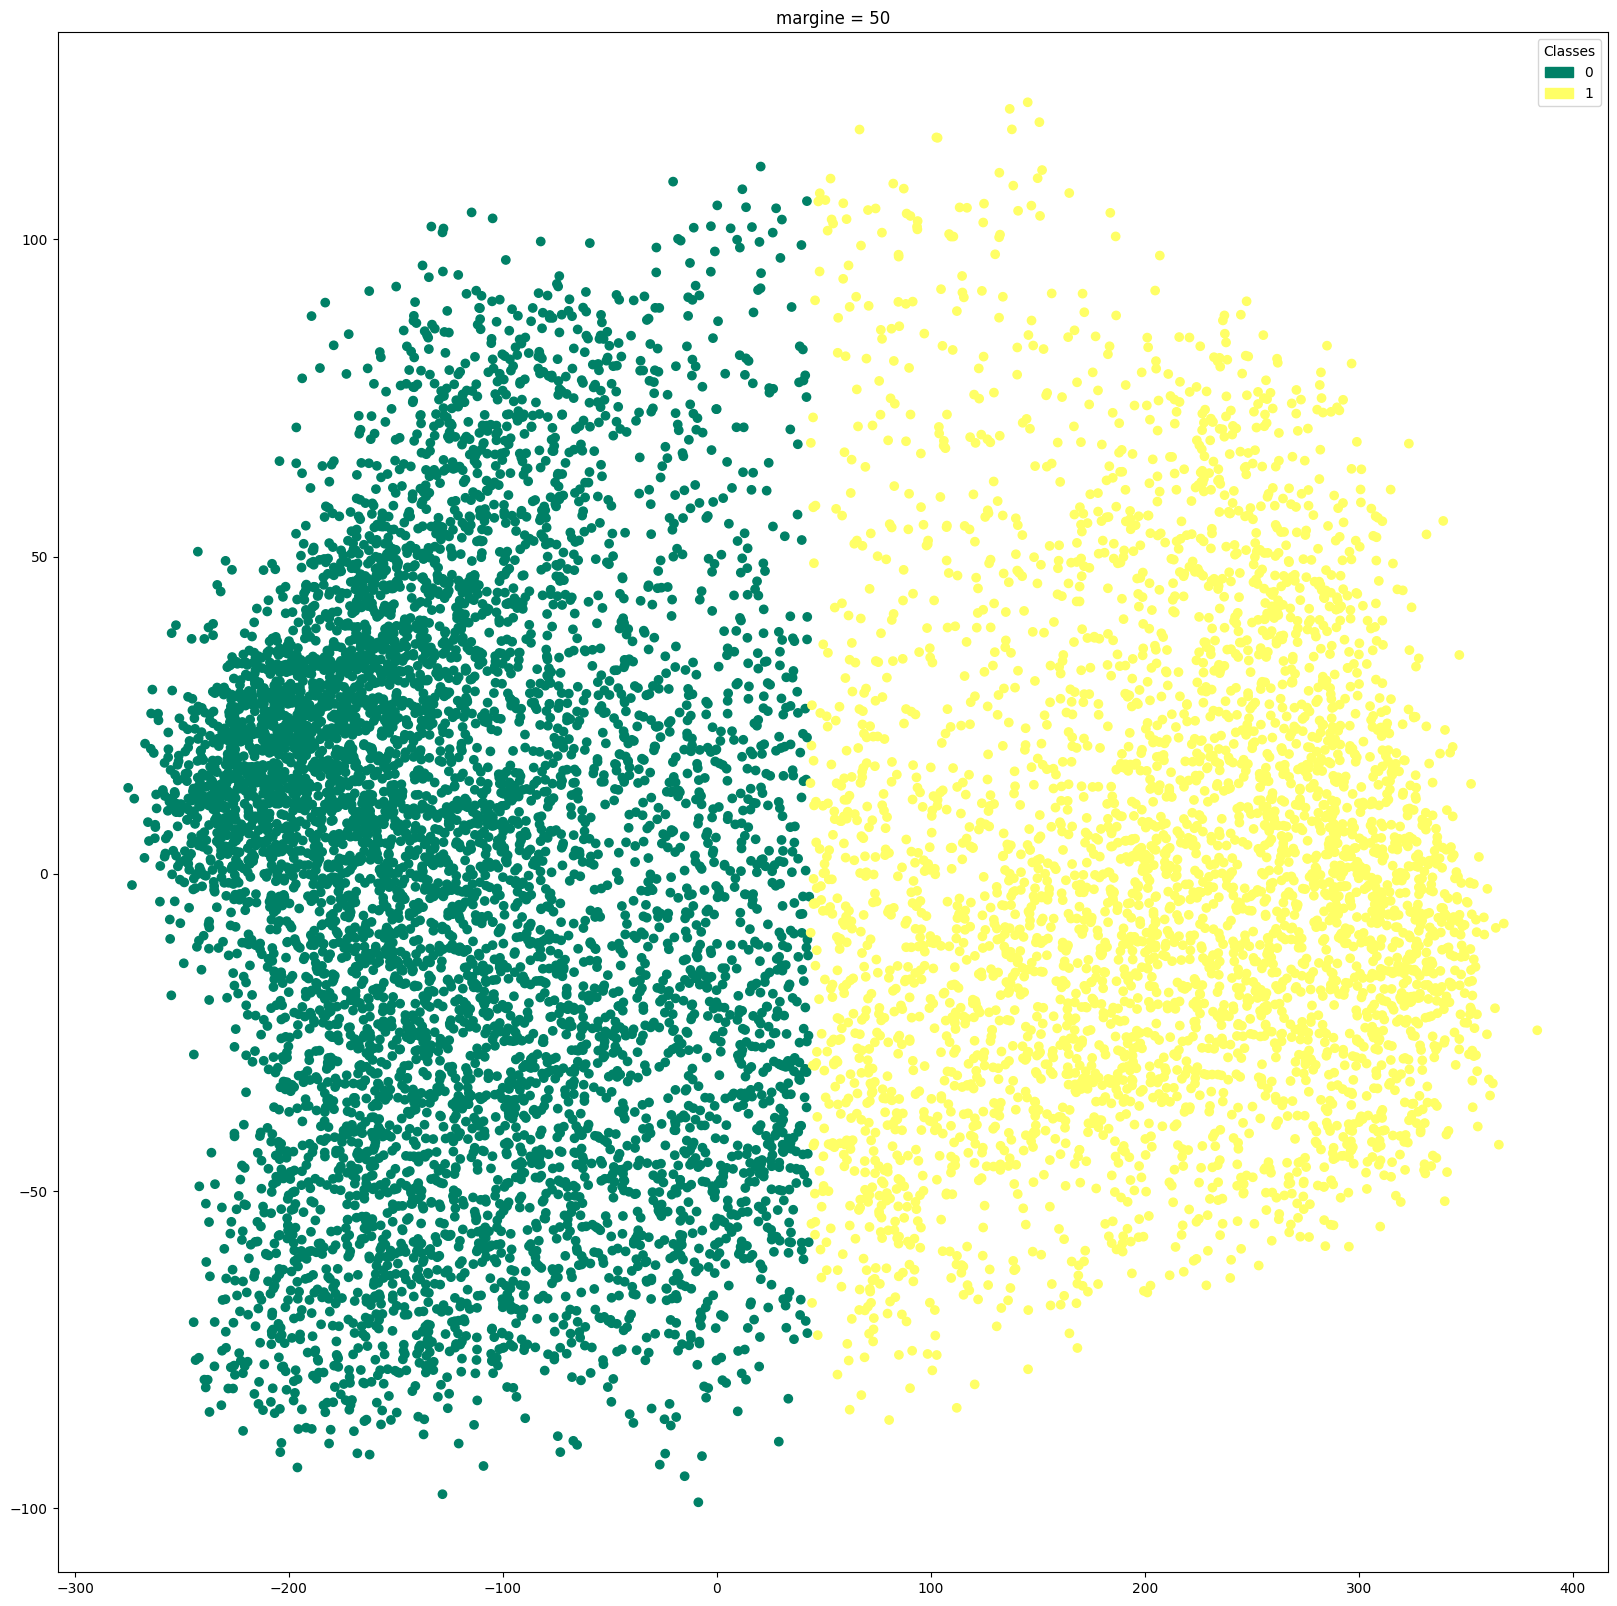

In [54]:
# Visiualize clusters
num_classes = len(np.unique(pred))  # Assuming pred is your class labels
cmap = plt.cm.get_cmap('summer', num_classes)  
plt.figure(figsize=(20,20))
plt.scatter(composition[:,0],composition[:,1],c=cmap(pred))
# Create a legend
labels = np.unique(pred)  # Get unique class labels
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(num_classes)]
legend_labels = [str(label) for label in labels]  # Convert labels to strings
plt.legend(legend_handles, legend_labels, title='Classes')
plt.title(f"margine = 50");

In [55]:
l.shape

(10275, 16640)

## Find Train Accuracy

In [72]:
train_result = {"Path":[],
               "True_label":[],
               "0_prop":[],
               "1_prop":[]}
num_folder = len(os.listdir(train_dir))
with torch.inference_mode():
    for class_path in os.listdir(train_dir):
        if class_path in ["0","1","2"]:
            True_label = class_path
            class_path = os.path.join(train_dir,class_path)
            for folder_path in os.listdir(class_path):
                folder_path = os.path.join(class_path,folder_path)
                print(folder_path)
                l = []
                if folder_path in Others_train_subjects.values:
                    for image_path in tqdm(os.listdir(folder_path)):
                        # print(image_path)
                        img = my_transform(Image.open(os.path.join(folder_path , image_path)).convert("RGB")).unsqueeze(dim=0)
                        # print(img.shape)
                        out = AmirModel.forward_once(img.to(device))
                        l.append(out.squeeze().detach().cpu().numpy())
                    l = np.asarray(l)
                    pred = kmeans.predict(l.reshape(l.shape[0],-1))
                    prob = pd.DataFrame(pred).value_counts(normalize=True)
                    train_result["Path"].append(folder_path)
                    train_result["True_label"].append(True_label)
                    try:
                        train_result["0_prop"].append(prob[0])
                    except:
                        train_result["0_prop"].append(0)
                    try:
                        train_result["1_prop"].append(prob[1])
                    except:
                        train_result["1_prop"].append(0)

../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (9)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 282.35it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:01<00:00, 270.25it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 286.12it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (15)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 280.47it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (7)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 287.82it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (16)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 234.15it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:01<00:00, 279.11it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (14)
../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (19)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 250.21it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 266.68it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (10)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 253.85it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (20)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 294.38it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (22)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 276.74it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (18)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:01<00:00, 267.93it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 282.60it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 285.10it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (23)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 283.44it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (5)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 256.13it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (11)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 282.35it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (21)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 287.01it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 264.30it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (4)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 259.98it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (6)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 281.46it/s]


../../ICIP_denoised_data/Data_1/train/1/RawDataQA-1 (17)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 280.20it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (9)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (21)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (12)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (20)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (10)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (13)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (17)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (16)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (11)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (5)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (19)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (8)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (22)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (18)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (14)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (15)
../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (23)
../../ICIP_denoised_data/Data_1/tr

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 278.80it/s]


../../ICIP_denoised_data/Data_1/train/2/RawDataQA-2 (7)
../../ICIP_denoised_data/Data_1/train/0/RawDataQA (10)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:01<00:00, 260.18it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (20)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 272.16it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 284.26it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (13)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 273.30it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (33)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:00<00:00, 283.73it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (7)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 284.52it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (29)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 279.76it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (30)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 271.35it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (22)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 273.27it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (21)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 274.23it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 281.67it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (8)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 270.57it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (9)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 257.66it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 276.30it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 273.30it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (14)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 270.18it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (19)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 275.27it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (32)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 277.15it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 275.81it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (34)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 272.21it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (15)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 275.18it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (23)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 277.30it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (18)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 268.25it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 271.29it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (26)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 274.69it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (25)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:01<00:00, 273.79it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (16)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 245.88it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (27)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 294.14it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 236.69it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (6)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 300.49it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 298.97it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (11)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 282.75it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (31)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 260.91it/s]


../../ICIP_denoised_data/Data_1/train/0/RawDataQA (17)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 256.07it/s]


In [73]:
train_results = pd.DataFrame(train_result)
train_results

,Path,True_label,0_prop,1_prop
0,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.068750,0.931250
1,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.010033,0.989967
2,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.046667,0.953333
3,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.047619,0.952381
4,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.006329,0.993671
5,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.054545,0.945455
6,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.064846,0.935154
7,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.000000,1.000000
8,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.309278,0.690722
9,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.013158,0.986842


In [74]:
train_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Path        58 non-null     object 
 1   True_label  58 non-null     object 
 2   0_prop      58 non-null     float64
 3   1_prop      58 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.9+ KB


In [75]:
train_results.drop(columns=["Path"]).groupby(["True_label"]).mean()

,0_prop,1_prop
True_label,,
0,0.923037,0.076963
1,0.124165,0.875835
2,0.038462,0.961538


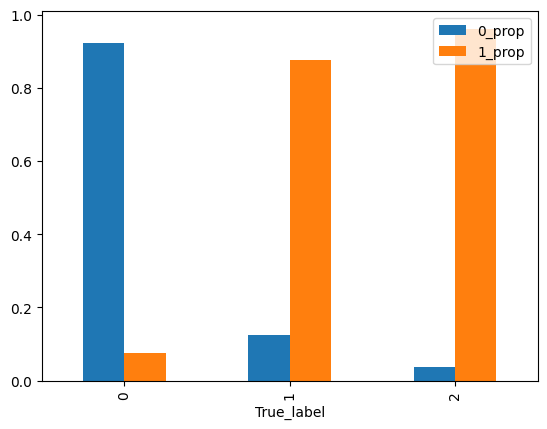

In [76]:
train_results.drop(columns=["Path"]).groupby(["True_label"]).mean().plot(kind="bar");

## Find Test Classes

In [77]:
test_result = {"Path":[],
               "True_label":[],
               "0_prop":[],
               "1_prop":[]}
num_folder = len(os.listdir(test_dir))
with torch.inference_mode():
    for class_path in os.listdir(test_dir):
        if class_path in ["0","1","2"]:
            True_label = class_path
            class_path = os.path.join(test_dir,class_path)
            for folder_path in os.listdir(class_path):
                folder_path = os.path.join(class_path,folder_path)
                print(folder_path)
                l = []
                if folder_path in Others_test_subjects.values:
                    for image_path in tqdm(os.listdir(folder_path)):
                        # print(image_path)
                        img = my_transform(Image.open(os.path.join(folder_path , image_path)).convert("RGB")).unsqueeze(dim=0)
                        # print(img.shape)
                        out = AmirModel.forward_once(img.to(device))
                        l.append(out.squeeze().detach().cpu().numpy())
                    l = np.asarray(l)
                    pred = kmeans.predict(l.reshape(l.shape[0],-1))
                    prob = pd.DataFrame(pred).value_counts(normalize=True)
                    test_result["Path"].append(folder_path)
                    test_result["True_label"].append(True_label)
                    try:
                        test_result["0_prop"].append(prob[0])
                    except:
                        test_result["0_prop"].append(0)
                    try:
                        test_result["1_prop"].append(prob[1])
                    except:
                        test_result["1_prop"].append(0)

../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (25)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 291.49it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (29)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 260.15it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [00:01<00:00, 290.23it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (30)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 266.39it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (26)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:01<00:00, 264.27it/s]


../../ICIP_denoised_data/Data_1/test/1/RawDataQA-1 (27)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 260.63it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (25)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 279.15it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (27)
../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (24)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 266.30it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (28)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 266.51it/s]


../../ICIP_denoised_data/Data_1/test/2/RawDataQA-2 (26)
../../ICIP_denoised_data/Data_1/test/0/RawDataQA (41)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 284.13it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (38)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 278.95it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (37)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:01<00:00, 268.80it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (42)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 269.19it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (35)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:01<00:00, 264.65it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (36)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:01<00:00, 255.61it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (40)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 273.12it/s]


../../ICIP_denoised_data/Data_1/test/0/RawDataQA (39)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 260.92it/s]


In [78]:
test_results = pd.DataFrame(test_result)
test_results

,Path,True_label,0_prop,1_prop
0,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.117647,0.882353
1,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.886878,0.113122
2,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.392617,0.607383
3,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.123239,0.876761
4,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.265306,0.734694
5,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.196203,0.803797
6,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,1.000000,0.000000
7,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.926230,0.073770
8,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.179688,0.820312
9,../../ICIP_denoised_data/Data_1/test/0/RawData...,0,1.000000,0.000000


In [79]:
test_results.drop(columns=["Path"]).groupby(["True_label"]).mean()

,0_prop,1_prop
True_label,,
0,0.790410,0.209590
1,0.330315,0.669685
2,0.701972,0.298028


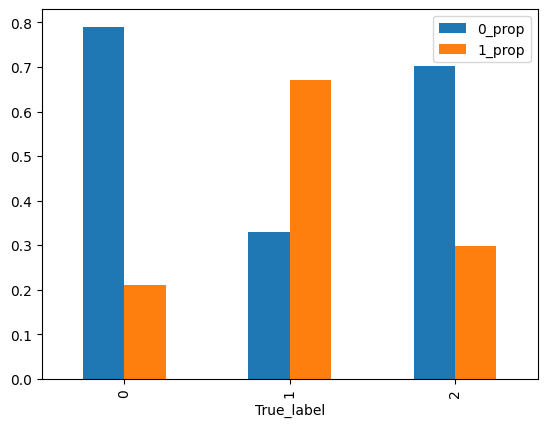

In [80]:
test_results.drop(columns=["Path"]).groupby(["True_label"]).mean().plot(kind="bar");

## Pred for each folder 

In [81]:
idx_to_label = {0:"Normal",
               1:"Diabetic",
               2:"non-Diabetic"}


In [82]:
thereshold = 0.5
def pred(x):
    p = 0
    if x["0_prop"] > x["1_prop"] :
            p = "0"
    else:
        p = "1"
    return p

In [83]:
train_results["Pred"] = train_results.apply(pred,axis=1)
train_results.to_csv("./Results/Second_step_train.csv",index=False)

In [84]:
train_results

,Path,True_label,0_prop,1_prop,Pred
0,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.068750,0.931250,1
1,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.010033,0.989967,1
2,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.046667,0.953333,1
3,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.047619,0.952381,1
4,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.006329,0.993671,1
5,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.054545,0.945455,1
6,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.064846,0.935154,1
7,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.000000,1.000000,1
8,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.309278,0.690722,1
9,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,0.013158,0.986842,1


In [85]:
(train_results["True_label"] == train_results["Pred"]).sum() / len(train_results)

0.9655172413793104

In [86]:
train_results[(train_results["True_label"] != train_results["Pred"])].to_csv("./Results/Second_step_mistakes_train.csv",index=False)

## Pred for each Test folder

In [87]:
test_results["Pred"] = test_results.apply(pred,axis=1)
test_results.to_csv("./Results/Second_step_test.csv",index=False)

In [88]:
test_results

,Path,True_label,0_prop,1_prop,Pred
0,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.117647,0.882353,1
1,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.886878,0.113122,0
2,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.392617,0.607383,1
3,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.123239,0.876761,1
4,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.265306,0.734694,1
5,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0.196203,0.803797,1
6,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,1.000000,0.000000,0
7,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.926230,0.073770,0
8,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0.179688,0.820312,1
9,../../ICIP_denoised_data/Data_1/test/0/RawData...,0,1.000000,0.000000,0


In [89]:
(test_results["True_label"] == test_results["Pred"]).sum() / len(test_results)

0.7058823529411765

In [90]:
test_results[(test_results["True_label"] != test_results["Pred"])].to_csv("./Results/Seconds_step_test_mistakes.csv",index=False)

## Make confusion Matrix


In [91]:
final_train_result = {"Path":[],"True_label":[],"Pred":[]}
final_train_result["Path"] = Dme_train_subjects
final_train_result ["Pred"] = "2"
final_train_result["True_label"] = First_clf_train_df[First_clf_train_df["PRED"] == "2"]["True_label"]
final_train_result_df = pd.concat([pd.DataFrame(final_train_result) , train_results[["Path","Pred","True_label"]]],axis=0)
final_train_result_df.to_csv("./Results/Final_train_results.csv",index=False)
final_train_result_df

,Path,True_label,Pred
7,../../ICIP_denoised_data/Data_1/train/1/RawDat...,1,2
24,../../ICIP_denoised_data/Data_1/train/2/RawDat...,2,2
25,../../ICIP_denoised_data/Data_1/train/2/RawDat...,2,2
26,../../ICIP_denoised_data/Data_1/train/2/RawDat...,2,2
27,../../ICIP_denoised_data/Data_1/train/2/RawDat...,2,2
...,...,...,...
53,../../ICIP_denoised_data/Data_1/train/0/RawDat...,0,0
54,../../ICIP_denoised_data/Data_1/train/0/RawDat...,0,0
55,../../ICIP_denoised_data/Data_1/train/0/RawDat...,0,0
56,../../ICIP_denoised_data/Data_1/train/0/RawDat...,0,0


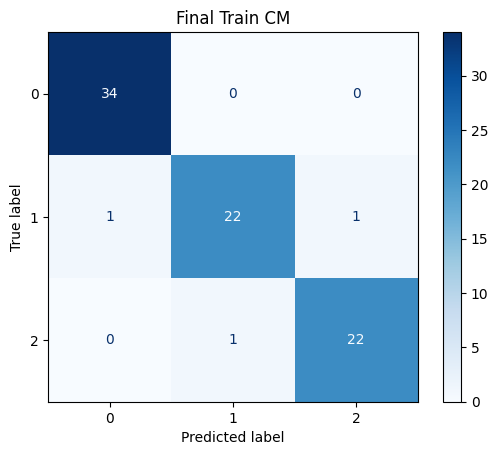

In [92]:
# make confustion matrix for train class
draw_cm(final_train_result_df["True_label"],final_train_result_df["Pred"],"Final Train CM")


In [93]:
final_test_result = {"Path":[],"True_label":[],"Pred":[]}
final_test_result["Path"] = Dme_test_subjects
final_test_result ["Pred"] = "2"
final_test_result["True_label"] = First_clf_test_df[First_clf_test_df["PRED"] == "2"]["True_label"]
final_test_result_df = pd.concat([pd.DataFrame(final_test_result) , test_results[["Path","Pred","True_label"]]],axis=0)
final_test_result_df.to_csv("Final_test_results.csv",index=False)
final_test_result_df

,Path,True_label,Pred
7,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,2
10,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,2
0,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,1
1,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,0
2,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,1
3,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,1
4,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,1
5,../../ICIP_denoised_data/Data_1/test/1/RawData...,1,1
6,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0
7,../../ICIP_denoised_data/Data_1/test/2/RawData...,2,0


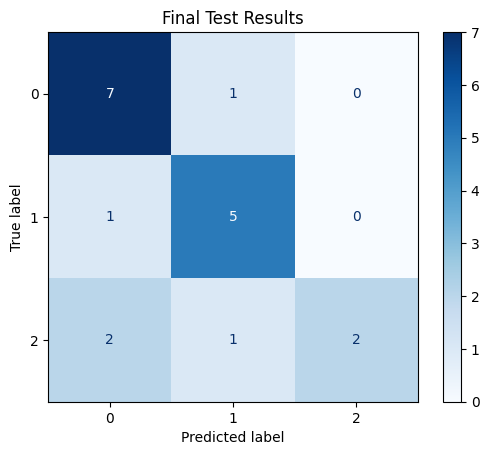

In [94]:
draw_cm(final_test_result_df["True_label"],final_test_result_df["Pred"],"Final Test Results")

95 , 73.6

93.82 ,  73.68

In [93]:
# Ensure your labels are numerical (0, 1, 2, 3 for the four classes)
# If they are strings, use label encoding techniques

# Create a confusion matrix
cm = test_cm

# Calculate sensitivity (recall) and specificity for each class
num_classes = 3  # Assuming unique class labels (0 to num_classes-1)
sensitivity = 0
specificity = 0
for class_index in range(num_classes):
  # Extract true positives, true negatives, false positives, and false negatives
  tp = cm[class_index, class_index]
  tn = sum(cm[i, j] for i in range(num_classes) for j in range(num_classes) if i != class_index and j != class_index)
  fp = sum(cm[i, class_index] for i in range(num_classes) if i != class_index)
  fn = sum(cm[class_index, j] for j in range(num_classes) if j != class_index)

  # Calculate sensitivity (recall)
  sensitivity += tp / (tp + fn) if (tp + fn) > 0 else 0

  # Calculate specificity
  specificity += tn / (tn + fp) if (tn + fp) > 0 else 0

# Print results for each class
# print(f"Class {class_index + 1}:")
print(f"\tSensitivity (Recall): {sensitivity/4}")
print(f"\tSpecificity: {specificity/4}")
print()


NameError: name 'test_cm' is not defined

In [117]:
# Ensure your labels are numerical (0, 1, 2, 3 for the four classes)
# If they are strings, use label encoding techniques

# Create a confusion matrix
cm = train_cm

# Calculate sensitivity (recall) and specificity for each class
num_classes = 3  # Assuming unique class labels (0 to num_classes-1)
sensitivity = 0
specificity = 0
for class_index in range(num_classes):
  # Extract true positives, true negatives, false positives, and false negatives
  tp = cm[class_index, class_index]
  tn = sum(cm[i, j] for i in range(num_classes) for j in range(num_classes) if i != class_index and j != class_index)
  fp = sum(cm[i, class_index] for i in range(num_classes) if i != class_index)
  fn = sum(cm[class_index, j] for j in range(num_classes) if j != class_index)

  # Calculate sensitivity (recall)
  sensitivity += tp / (tp + fn) if (tp + fn) > 0 else 0

  # Calculate specificity
  specificity += tn / (tn + fp) if (tn + fp) > 0 else 0

# Print results for each class
# print(f"Class {class_index + 1}:")
print(f"\tSensitivity (Recall): {sensitivity/4}")
print(f"\tSpecificity: {specificity/4}")
print()


	Sensitivity (Recall): 0.7113970588235294
	Specificity: 0.7316741964963767

